# Đánh giá thuật toán so sánh ảnh sử dụng Wavelet Transform

### Mục tiêu:
- Sử dụng wavelet để trích xuất đặc trưng từ hình ảnh
- So sánh độ tương đồng giữa các cặp hình ảnh
- Đánh giá hiệu suất thuật toán thông qua:
  - Độ chính xác (Accuracy)
  - Độ nhạy (Sensitivity/Recall)
  - Độ đặc biệt (Specificity)
  - Đường cong ROC

## 1. Import thư viện

In [3]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score
import seaborn as sns
from skimage import data
from scipy.spatial.distance import euclidean, cosine
import warnings
warnings.filterwarnings('ignore')

## 2. Hàm trích xuất đặc trưng sử dụng Wavelet Transform

In [4]:
def extract_wavelet_features(image, wavelet='db1', level=3):
    """
    Trích xuất đặc trưng từ ảnh sử dụng Discrete Wavelet Transform (DWT)
    
    Parameters:
    - image: Ảnh đầu vào (grayscale)
    - wavelet: Loại wavelet (db1, haar, sym, coif, etc.)
    - level: Số cấp độ phân rã
    
    Returns:
    - feature_vector: Vector đặc trưng từ các hệ số wavelet
    """
    # Đảm bảo ảnh là grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Chuẩn hóa kích thước ảnh (phải là lũy thừa của 2)
    h, w = image.shape
    new_h = 2 ** int(np.ceil(np.log2(h)))
    new_w = 2 ** int(np.ceil(np.log2(w)))
    image_resized = cv2.resize(image, (new_w, new_h))
    
    # Áp dụng DWT 2D
    coeffs = pywt.wavedec2(image_resized, wavelet=wavelet, level=level)
    
    # Trích xuất đặc trưng từ các hệ số
    # coeffs[0]: Hệ số xấp xỉ (approximation)
    # coeffs[1:]: Các hệ số chi tiết (details) - (cH, cV, cD)
    
    features = []
    
    # Đặc trưng từ hệ số xấp xỉ
    cA = coeffs[0]
    features.extend([
        np.mean(cA),
        np.std(cA),
        np.median(cA),
        np.max(cA),
        np.min(cA)
    ])
    
    # Đặc trưng từ các hệ số chi tiết
    for i in range(1, len(coeffs)):
        cH, cV, cD = coeffs[i]
        
        for coeff in [cH, cV, cD]:
            features.extend([
                np.mean(np.abs(coeff)),
                np.std(coeff),
                np.sum(coeff ** 2)  # Năng lượng
            ])
    
    return np.array(features)


def visualize_wavelet_decomposition(image, wavelet='db1', level=2):
    """
    Hiển thị phân rã wavelet của ảnh
    """
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    h, w = image.shape
    new_h = 2 ** int(np.ceil(np.log2(h)))
    new_w = 2 ** int(np.ceil(np.log2(w)))
    image_resized = cv2.resize(image, (new_w, new_h))
    
    coeffs = pywt.wavedec2(image_resized, wavelet=wavelet, level=level)
    
    # Tạo ảnh để hiển thị
    arr, slices = pywt.coeffs_to_array(coeffs)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(np.abs(arr), cmap='gray')
    plt.title(f'Wavelet Decomposition (Level {level}, {wavelet})')
    plt.colorbar()
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return coeffs

## 3. Hàm tính độ tương đồng giữa 2 ảnh

In [5]:
def calculate_similarity(image1, image2, wavelet='db1', level=3, method='euclidean'):
    """
    Tính độ tương đồng giữa 2 ảnh dựa trên đặc trưng wavelet
    
    Parameters:
    - image1, image2: Hai ảnh cần so sánh
    - wavelet: Loại wavelet
    - level: Cấp độ phân rã
    - method: Phương pháp tính khoảng cách ('euclidean', 'cosine', 'correlation')
    
    Returns:
    - similarity_score: Điểm tương đồng (càng nhỏ càng giống với euclidean)
    """
    # Trích xuất đặc trưng
    features1 = extract_wavelet_features(image1, wavelet, level)
    features2 = extract_wavelet_features(image2, wavelet, level)
    
    # Tính khoảng cách
    if method == 'euclidean':
        distance = euclidean(features1, features2)
    elif method == 'cosine':
        distance = cosine(features1, features2)
    elif method == 'correlation':
        distance = 1 - np.corrcoef(features1, features2)[0, 1]
    else:
        distance = euclidean(features1, features2)
    
    return distance


def similarity_to_probability(distance, threshold=None):
    """
    Chuyển đổi khoảng cách thành xác suất tương đồng
    Sử dụng hàm sigmoid để chuẩn hóa
    """
    if threshold is None:
        threshold = 100  # Giá trị mặc định
    
    # Sử dụng sigmoid: probability = 1 / (1 + exp(distance / threshold))
    probability = 1 / (1 + np.exp(distance / threshold))
    return probability

## 4. Tạo dữ liệu test (các cặp ảnh)

In [6]:
def create_test_dataset():
    """
    Tạo dataset test gồm các cặp ảnh với nhãn (tương tự/không tương tự)
    """
    # Tải các ảnh mẫu từ scikit-image
    img1 = data.camera()  # Ảnh camera
    img2 = data.astronaut()  # Ảnh astronaut
    img3 = data.coins()  # Ảnh coins
    img4 = data.moon()  # Ảnh moon
    img5 = data.text()  # Ảnh text
    
    # Tạo các biến thể của ảnh (tương tự)
    img1_noisy = (data.camera() + np.random.normal(0, 10, data.camera().shape)).astype(np.uint8)
    img1_rotated = np.rot90(data.camera())
    img1_scaled = cv2.resize(data.camera(), (300, 300))
    img1_scaled = cv2.resize(img1_scaled, (512, 512))
    img1_bright = np.clip(data.camera() * 1.3, 0, 255).astype(np.uint8)
    
    img2_noisy = cv2.cvtColor((data.astronaut() + np.random.normal(0, 5, data.astronaut().shape)).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    img2_rotated = np.rot90(cv2.cvtColor(data.astronaut(), cv2.COLOR_RGB2GRAY))
    
    # Tạo danh sách các cặp ảnh và nhãn
    # Label: 1 = Tương tự (cùng nguồn gốc), 0 = Không tương tự
    image_pairs = []
    labels = []
    
    # Các cặp TƯƠNG TỰ (Positive pairs) - Label = 1
    similar_pairs = [
        (img1, img1_noisy, "Camera - Camera nhiễu"),
        (img1, img1_rotated, "Camera - Camera xoay"),
        (img1, img1_scaled, "Camera - Camera scale"),
        (img1, img1_bright, "Camera - Camera sáng"),
        (cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY), img2_noisy, "Astronaut - Astronaut nhiễu"),
        (cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY), img2_rotated, "Astronaut - Astronaut xoay"),
    ]
    
    # Các cặp KHÔNG TƯƠNG TỰ (Negative pairs) - Label = 0
    dissimilar_pairs = [
        (img1, cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY), "Camera - Astronaut"),
        (img1, img3, "Camera - Coins"),
        (img1, img4, "Camera - Moon"),
        (img1, img5, "Camera - Text"),
        (cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY), img3, "Astronaut - Coins"),
        (cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY), img4, "Astronaut - Moon"),
        (img3, img4, "Coins - Moon"),
        (img3, img5, "Coins - Text"),
        (img4, img5, "Moon - Text"),
    ]
    
    # Thêm vào dataset
    for pair in similar_pairs:
        image_pairs.append((pair[0], pair[1], pair[2]))
        labels.append(1)
    
    for pair in dissimilar_pairs:
        image_pairs.append((pair[0], pair[1], pair[2]))
        labels.append(0)
    
    return image_pairs, np.array(labels)


# Tạo dataset
image_pairs, true_labels = create_test_dataset()
print(f"Tổng số cặp ảnh: {len(image_pairs)}")
print(f"Số cặp tương tự: {np.sum(true_labels == 1)}")
print(f"Số cặp không tương tự: {np.sum(true_labels == 0)}")

Tổng số cặp ảnh: 15
Số cặp tương tự: 6
Số cặp không tương tự: 9


## 5. Hiển thị một số cặp ảnh mẫu

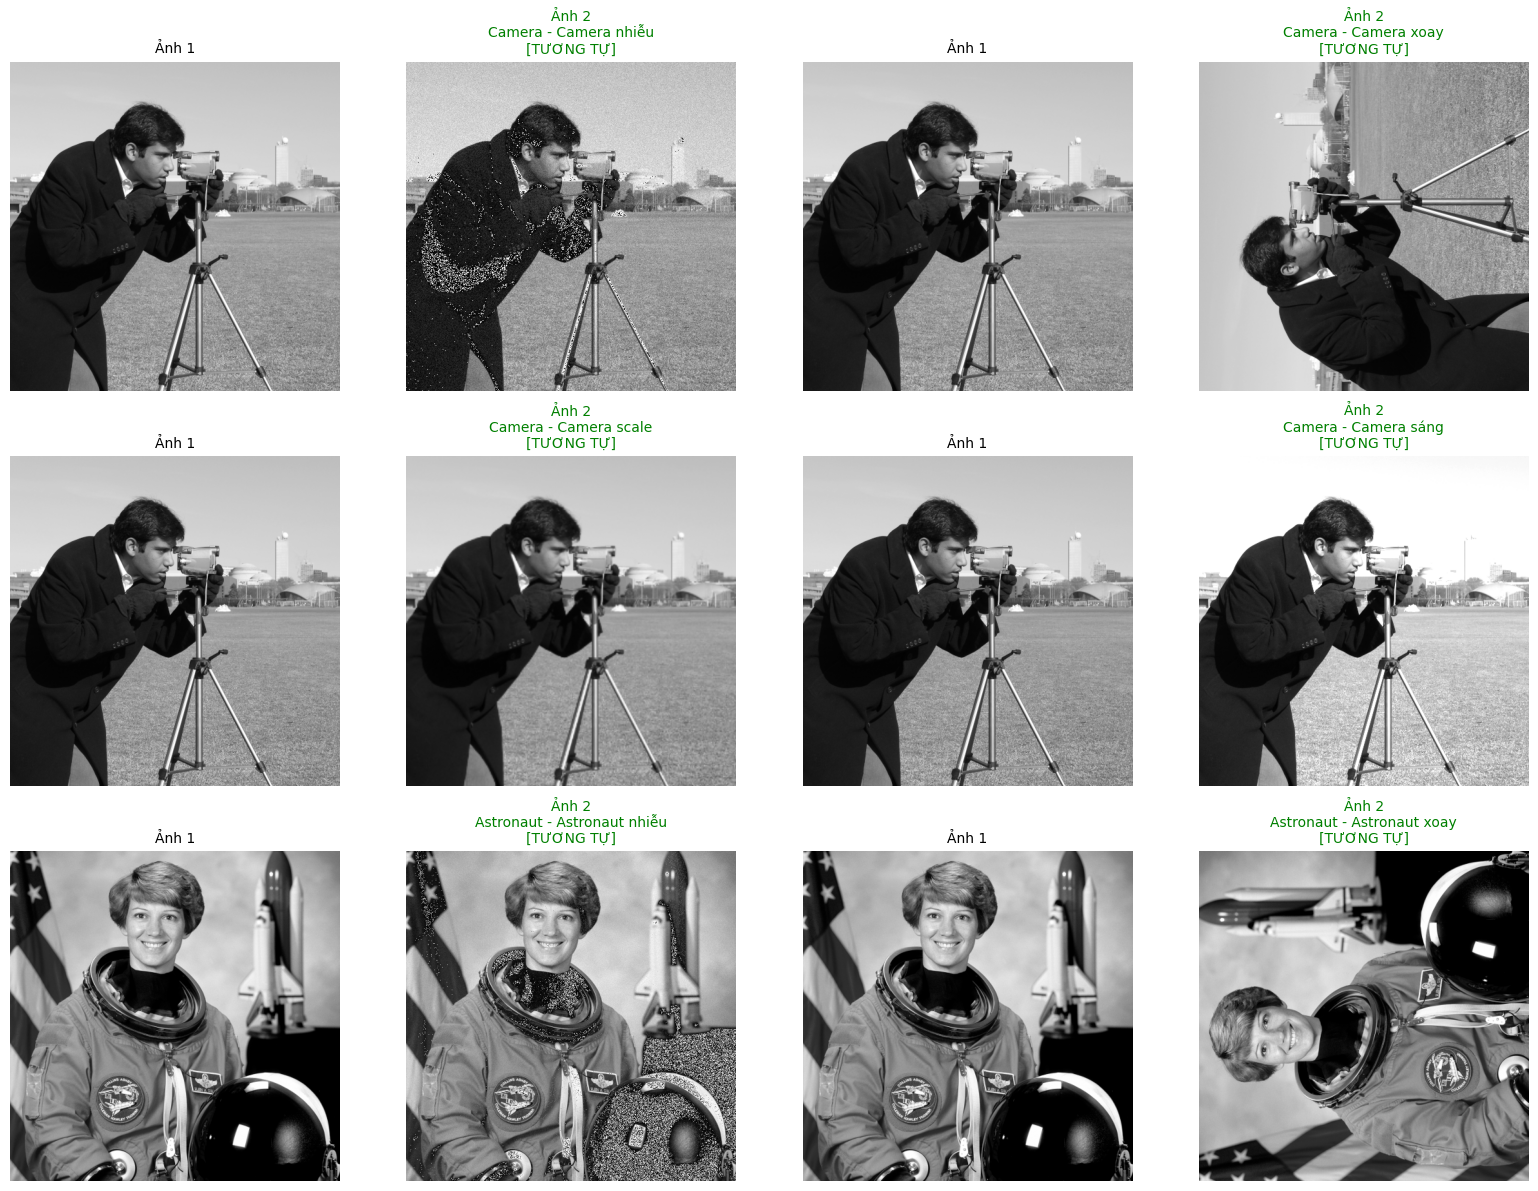

In [7]:
# Hiển thị một số cặp ảnh
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for idx in range(6):
    img1, img2, desc = image_pairs[idx]
    label = "TƯƠNG TỰ" if true_labels[idx] == 1 else "KHÔNG TƯƠNG TỰ"
    
    row = idx // 2
    col = (idx % 2) * 2
    
    axes[row, col].imshow(img1, cmap='gray')
    axes[row, col].set_title(f'Ảnh 1', fontsize=10)
    axes[row, col].axis('off')
    
    axes[row, col+1].imshow(img2, cmap='gray')
    axes[row, col+1].set_title(f'Ảnh 2\n{desc}\n[{label}]', fontsize=10, 
                                color='green' if label == "TƯƠNG TỰ" else 'red')
    axes[row, col+1].axis('off')

plt.tight_layout()
plt.savefig('results/sample_pairs.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Tính toán điểm tương đồng cho tất cả các cặp

In [8]:
# Tính khoảng cách cho tất cả các cặp
distances = []
probabilities = []

print("Đang tính toán độ tương đồng...")
for idx, (img1, img2, desc) in enumerate(image_pairs):
    distance = calculate_similarity(img1, img2, wavelet='db1', level=3, method='euclidean')
    prob = similarity_to_probability(distance, threshold=50)
    
    distances.append(distance)
    probabilities.append(prob)
    
    print(f"Cặp {idx+1}/{len(image_pairs)}: {desc[:30]:30s} | Distance: {distance:8.2f} | Prob: {prob:.4f} | Label: {true_labels[idx]}")

distances = np.array(distances)
probabilities = np.array(probabilities)

print("\n✓ Hoàn thành tính toán độ tương đồng!")

Đang tính toán độ tương đồng...
Cặp 1/15: Camera - Camera nhiễu          | Distance: 91980892.25 | Prob: 0.0000 | Label: 1
Cặp 2/15: Camera - Camera xoay           | Distance: 20298644.44 | Prob: 0.0000 | Label: 1
Cặp 3/15: Camera - Camera scale          | Distance: 12123369.12 | Prob: 0.0000 | Label: 1
Cặp 4/15: Camera - Camera sáng           | Distance: 15306856.90 | Prob: 0.0000 | Label: 1
Cặp 5/15: Astronaut - Astronaut nhiễu    | Distance: 125954997.73 | Prob: 0.0000 | Label: 1
Cặp 6/15: Astronaut - Astronaut xoay     | Distance: 19630833.51 | Prob: 0.0000 | Label: 1
Cặp 7/15: Camera - Astronaut             | Distance: 28560016.93 | Prob: 0.0000 | Label: 0
Cặp 8/15: Camera - Coins                 | Distance: 9940919.52 | Prob: 0.0000 | Label: 0
Cặp 9/15: Camera - Moon                  | Distance: 36157897.77 | Prob: 0.0000 | Label: 0
Cặp 10/15: Camera - Text                  | Distance: 31763020.19 | Prob: 0.0000 | Label: 0
Cặp 11/15: Astronaut - Coins              | Distance: 243

## 7. Tính toán các metrics đánh giá

In [9]:
def calculate_metrics_at_threshold(distances, true_labels, threshold):
    """
    Tính các metrics tại một ngưỡng cụ thể
    Nếu distance < threshold => Dự đoán = 1 (Tương tự)
    Nếu distance >= threshold => Dự đoán = 0 (Không tương tự)
    """
    # Dự đoán dựa trên ngưỡng (distance nhỏ = tương tự)
    predictions = (distances < threshold).astype(int)
    
    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(true_labels, predictions).ravel()
    
    # Tính các metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall / True Positive Rate
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    return {
        'threshold': threshold,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'predictions': predictions
    }


# Tìm ngưỡng tối ưu
thresholds_to_test = np.linspace(distances.min(), distances.max(), 50)
best_accuracy = 0
best_threshold = 0
best_metrics = None

for thresh in thresholds_to_test:
    metrics = calculate_metrics_at_threshold(distances, true_labels, thresh)
    if metrics['accuracy'] > best_accuracy:
        best_accuracy = metrics['accuracy']
        best_threshold = thresh
        best_metrics = metrics

print("=" * 70)
print("KẾT QUẢ ĐÁNH GIÁ TẠI NGƯỠNG TỐI ƯU")
print("=" * 70)
print(f"\nNgưỡng tối ưu: {best_threshold:.2f}")
print(f"\n{'Metric':<20} {'Giá trị':<15} {'Ý nghĩa'}")
print("-" * 70)
print(f"{'Accuracy':<20} {best_metrics['accuracy']:.4f} ({best_metrics['accuracy']*100:.2f}%)     Tỷ lệ phân loại đúng")
print(f"{'Sensitivity':<20} {best_metrics['sensitivity']:.4f} ({best_metrics['sensitivity']*100:.2f}%)     Phát hiện cặp tương tự")
print(f"{'Specificity':<20} {best_metrics['specificity']:.4f} ({best_metrics['specificity']*100:.2f}%)     Phát hiện cặp khác nhau")
print(f"{'Precision':<20} {best_metrics['precision']:.4f} ({best_metrics['precision']*100:.2f}%)     Độ chính xác dự đoán tương tự")
print("\nConfusion Matrix:")
print(f"  True Positive (TP):  {best_metrics['TP']:3d} - Tương tự được phân loại đúng")
print(f"  True Negative (TN):  {best_metrics['TN']:3d} - Khác nhau được phân loại đúng")
print(f"  False Positive (FP): {best_metrics['FP']:3d} - Khác nhau nhưng bị phân loại là tương tự")
print(f"  False Negative (FN): {best_metrics['FN']:3d} - Tương tự nhưng bị phân loại là khác nhau")
print("=" * 70)

KẾT QUẢ ĐÁNH GIÁ TẠI NGƯỠNG TỐI ƯU

Ngưỡng tối ưu: 21391039.72

Metric               Giá trị         Ý nghĩa
----------------------------------------------------------------------
Accuracy             0.7333 (73.33%)     Tỷ lệ phân loại đúng
Sensitivity          0.6667 (66.67%)     Phát hiện cặp tương tự
Specificity          0.7778 (77.78%)     Phát hiện cặp khác nhau
Precision            0.6667 (66.67%)     Độ chính xác dự đoán tương tự

Confusion Matrix:
  True Positive (TP):    4 - Tương tự được phân loại đúng
  True Negative (TN):    7 - Khác nhau được phân loại đúng
  False Positive (FP):   2 - Khác nhau nhưng bị phân loại là tương tự
  False Negative (FN):   2 - Tương tự nhưng bị phân loại là khác nhau


## 8. Vẽ Confusion Matrix

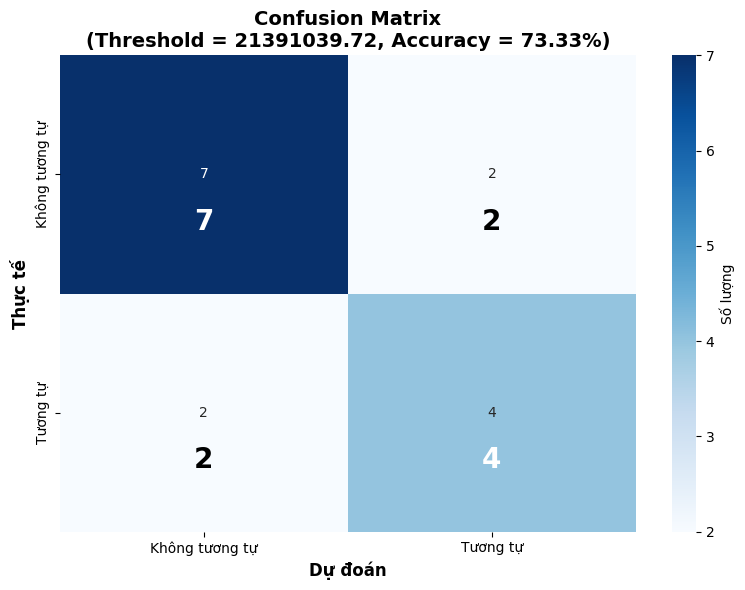

In [10]:
# Vẽ Confusion Matrix
cm = confusion_matrix(true_labels, best_metrics['predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Không tương tự', 'Tương tự'],
            yticklabels=['Không tương tự', 'Tương tự'],
            cbar_kws={'label': 'Số lượng'})

plt.xlabel('Dự đoán', fontsize=12, weight='bold')
plt.ylabel('Thực tế', fontsize=12, weight='bold')
plt.title(f'Confusion Matrix\n(Threshold = {best_threshold:.2f}, Accuracy = {best_metrics["accuracy"]:.2%})', 
          fontsize=14, weight='bold')

# Thêm annotations
for i in range(2):
    for j in range(2):
        plt.text(j + 0.5, i + 0.7, 
                f'{cm[i, j]}', 
                ha='center', va='center', 
                fontsize=20, weight='bold', color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.tight_layout()
plt.savefig('results/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Vẽ đường cong ROC (Receiver Operating Characteristic)

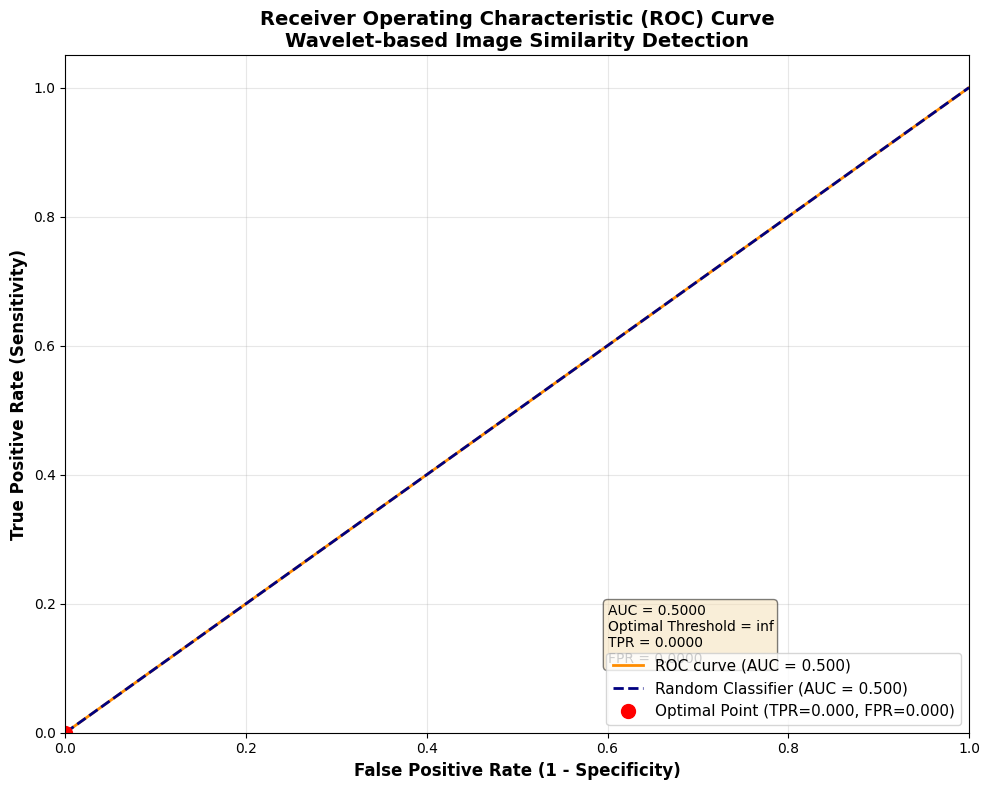


AUC (Area Under Curve): 0.5000

Giải thích AUC:
  - AUC = 1.0: Phân loại hoàn hảo
  - AUC = 0.9 - 1.0: Xuất sắc
  - AUC = 0.8 - 0.9: Tốt
  - AUC = 0.7 - 0.8: Khá
  - AUC = 0.5: Phân loại ngẫu nhiên (không có giá trị)
  - AUC < 0.5: Kém hơn ngẫu nhiên


In [11]:
# Tính ROC curve
# Chú ý: Với distance, giá trị nhỏ = tương tự
# Nên ta cần đảo ngược: scores = -distances hoặc 1/distances
# Hoặc sử dụng probabilities đã tính

# Sử dụng probabilities (xác suất tương tự)
fpr, tpr, thresholds_roc = roc_curve(true_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Vẽ ROC curve
plt.figure(figsize=(10, 8))

# Vẽ đường ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')

# Vẽ đường tham chiếu (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.500)')

# Đánh dấu điểm tối ưu
# Tìm điểm có Youden's Index cao nhất: J = TPR - FPR
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds_roc[optimal_idx]
optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]

plt.plot(optimal_fpr, optimal_tpr, 'ro', markersize=10, 
         label=f'Optimal Point (TPR={optimal_tpr:.3f}, FPR={optimal_fpr:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12, weight='bold')
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12, weight='bold')
plt.title('Receiver Operating Characteristic (ROC) Curve\nWavelet-based Image Similarity Detection', 
          fontsize=14, weight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)

# Thêm text box với thông tin
textstr = f'AUC = {roc_auc:.4f}\nOptimal Threshold = {optimal_threshold:.4f}\nTPR = {optimal_tpr:.4f}\nFPR = {optimal_fpr:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.6, 0.2, textstr, fontsize=10, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('results/roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n{'='*70}")
print(f"AUC (Area Under Curve): {roc_auc:.4f}")
print(f"{'='*70}")
print(f"\nGiải thích AUC:")
print(f"  - AUC = 1.0: Phân loại hoàn hảo")
print(f"  - AUC = 0.9 - 1.0: Xuất sắc")
print(f"  - AUC = 0.8 - 0.9: Tốt")
print(f"  - AUC = 0.7 - 0.8: Khá")
print(f"  - AUC = 0.5: Phân loại ngẫu nhiên (không có giá trị)")
print(f"  - AUC < 0.5: Kém hơn ngẫu nhiên")

## 10. Phân tích chi tiết hiệu suất ở các ngưỡng khác nhau

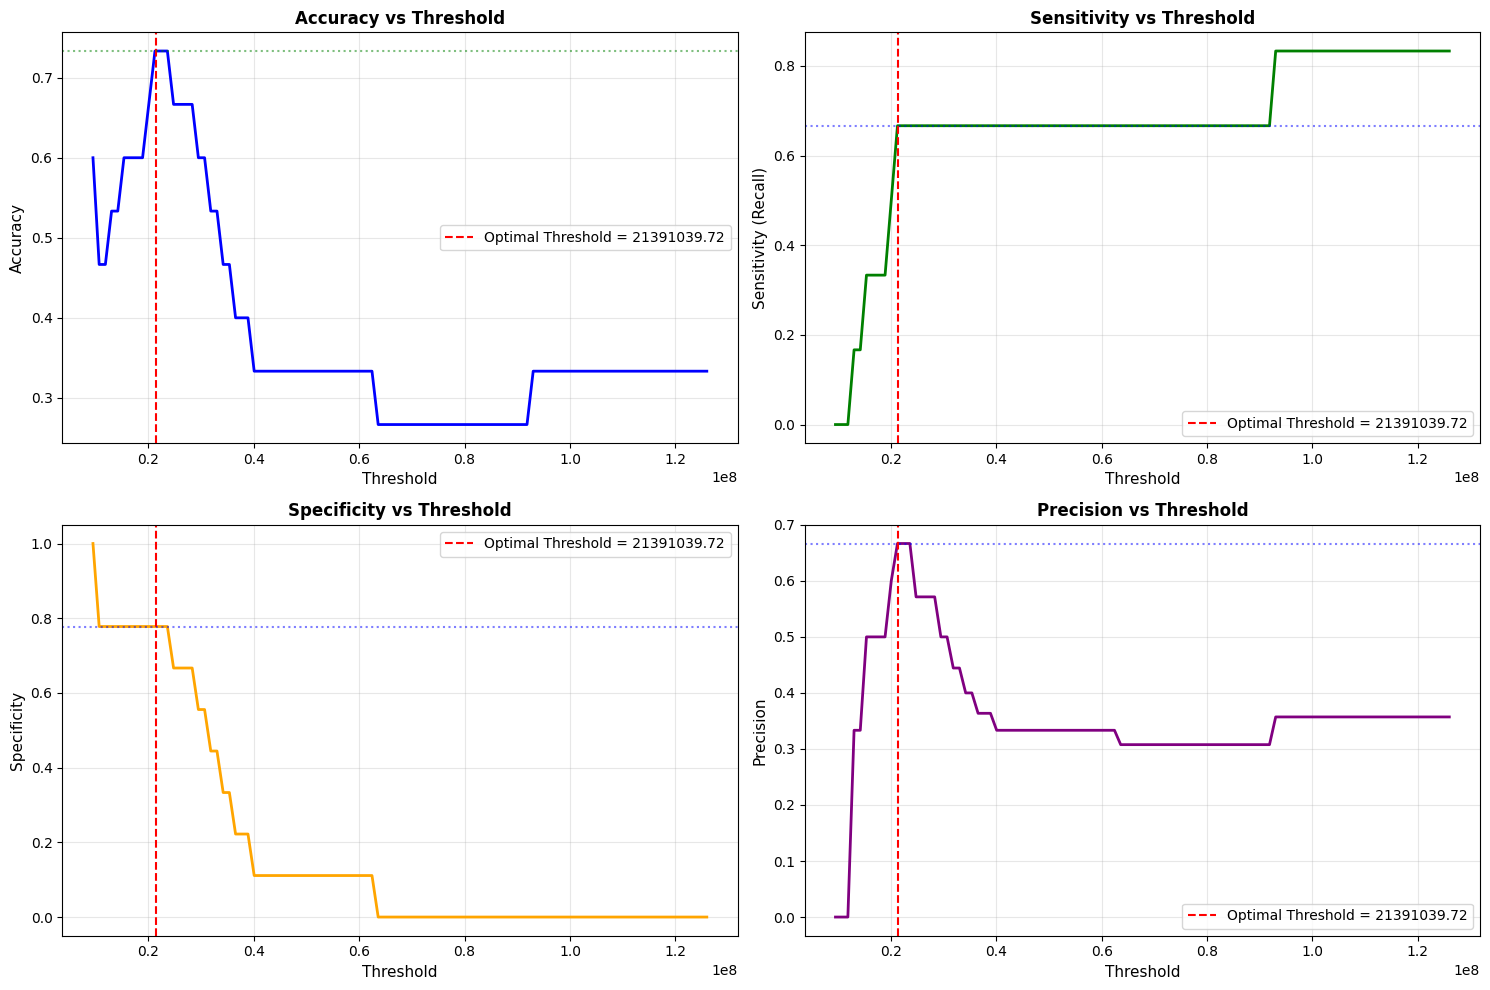

In [12]:
# Tính metrics cho nhiều ngưỡng
test_thresholds = np.linspace(distances.min(), distances.max(), 100)
metrics_list = []

for thresh in test_thresholds:
    metrics = calculate_metrics_at_threshold(distances, true_labels, thresh)
    metrics_list.append(metrics)

# Trích xuất các giá trị
accuracies = [m['accuracy'] for m in metrics_list]
sensitivities = [m['sensitivity'] for m in metrics_list]
specificities = [m['specificity'] for m in metrics_list]
precisions = [m['precision'] for m in metrics_list]

# Vẽ biểu đồ
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(test_thresholds, accuracies, 'b-', linewidth=2)
axes[0, 0].axvline(best_threshold, color='r', linestyle='--', label=f'Optimal Threshold = {best_threshold:.2f}')
axes[0, 0].axhline(best_metrics['accuracy'], color='g', linestyle=':', alpha=0.5)
axes[0, 0].set_xlabel('Threshold', fontsize=11)
axes[0, 0].set_ylabel('Accuracy', fontsize=11)
axes[0, 0].set_title('Accuracy vs Threshold', fontsize=12, weight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].legend()

# Sensitivity
axes[0, 1].plot(test_thresholds, sensitivities, 'g-', linewidth=2)
axes[0, 1].axvline(best_threshold, color='r', linestyle='--', label=f'Optimal Threshold = {best_threshold:.2f}')
axes[0, 1].axhline(best_metrics['sensitivity'], color='b', linestyle=':', alpha=0.5)
axes[0, 1].set_xlabel('Threshold', fontsize=11)
axes[0, 1].set_ylabel('Sensitivity (Recall)', fontsize=11)
axes[0, 1].set_title('Sensitivity vs Threshold', fontsize=12, weight='bold')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].legend()

# Specificity
axes[1, 0].plot(test_thresholds, specificities, 'orange', linewidth=2)
axes[1, 0].axvline(best_threshold, color='r', linestyle='--', label=f'Optimal Threshold = {best_threshold:.2f}')
axes[1, 0].axhline(best_metrics['specificity'], color='b', linestyle=':', alpha=0.5)
axes[1, 0].set_xlabel('Threshold', fontsize=11)
axes[1, 0].set_ylabel('Specificity', fontsize=11)
axes[1, 0].set_title('Specificity vs Threshold', fontsize=12, weight='bold')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].legend()

# Precision
axes[1, 1].plot(test_thresholds, precisions, 'purple', linewidth=2)
axes[1, 1].axvline(best_threshold, color='r', linestyle='--', label=f'Optimal Threshold = {best_threshold:.2f}')
axes[1, 1].axhline(best_metrics['precision'], color='b', linestyle=':', alpha=0.5)
axes[1, 1].set_xlabel('Threshold', fontsize=11)
axes[1, 1].set_ylabel('Precision', fontsize=11)
axes[1, 1].set_title('Precision vs Threshold', fontsize=12, weight='bold')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('results/metrics_vs_threshold.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Hiển thị ví dụ về wavelet decomposition

Wavelet Decomposition của ảnh mẫu:


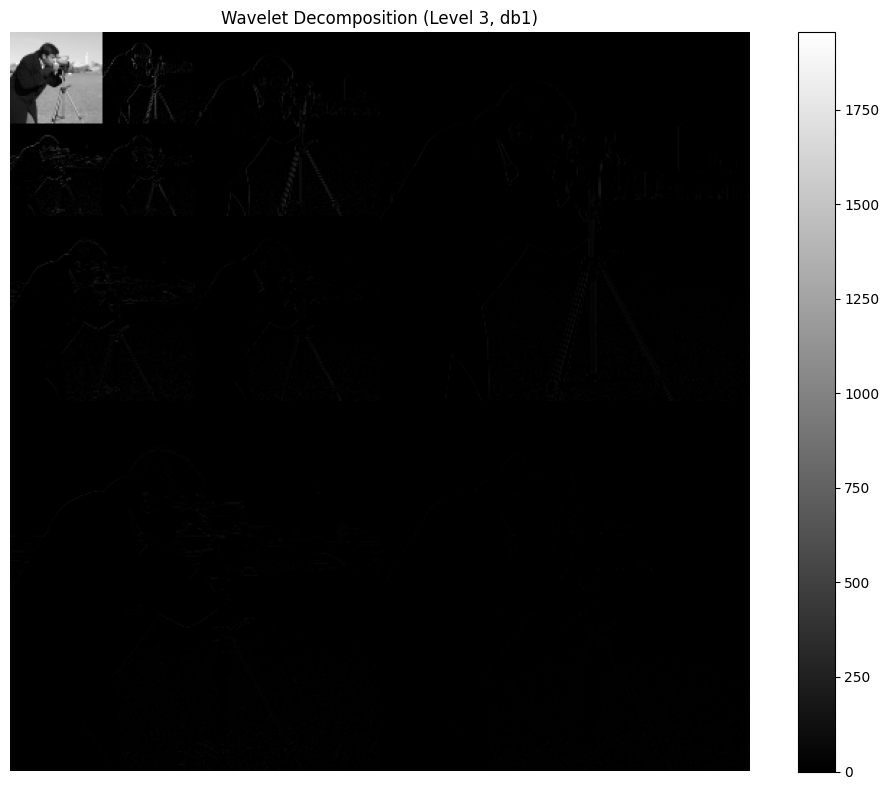

[array([[1596.   , 1590.375, 1587.625, ..., 1522.625, 1521.875, 1521.875],
        [1600.375, 1597.625, 1597.625, ..., 1529.625, 1529.375, 1527.125],
        [1606.5  , 1606.5  , 1606.5  , ..., 1540.5  , 1538.875, 1536.875],
        ...,
        [ 170.   ,  175.25 ,  187.25 , ..., 1151.375, 1215.5  , 1136.875],
        [ 191.5  ,  181.25 ,  182.125, ..., 1171.125, 1073.75 , 1142.875],
        [ 197.25 ,  191.125,  188.5  , ..., 1162.125, 1205.125, 1147.125]],
       shape=(64, 64)),
 (array([[ -0.75 ,  -1.625,  -1.625, ...,  -2.125,  -1.125,  -3.125],
         [ -0.625,  -2.375,  -2.625, ...,  -0.875,  -1.625,  -2.125],
         [ -2.5  ,  -2.   ,  -3.25 , ...,  -3.   ,  -2.875,  -4.125],
         ...,
         [ -7.75 ,   2.25 ,   1.   , ...,  43.125, -12.   ,  18.125],
         [ -1.75 ,  -3.25 ,  -0.125, ..., -38.375, -14.5  , -83.875],
         [ -2.5  ,  -1.375,  -1.75 , ...,  55.625,   5.125, -72.375]],
        shape=(64, 64)),
  array([[  2.25 ,   0.125,   0.375, ...,   1.875,  

In [13]:
# Hiển thị wavelet decomposition cho một ảnh mẫu
sample_image = data.camera()
print("Wavelet Decomposition của ảnh mẫu:")
visualize_wavelet_decomposition(sample_image, wavelet='db1', level=3)

## 12. Tổng kết và kết luận

### KẾT QUẢ ĐÁNH GIÁ THUẬT TOÁN

#### **1. Phương pháp:**
- Sử dụng **Discrete Wavelet Transform (DWT)** để trích xuất đặc trưng từ ảnh
- Wavelet: Daubechies 1 (db1)
- Cấp độ phân rã: 3 levels
- Trích xuất các đặc trưng thống kê từ:
  - Hệ số xấp xỉ (Approximation coefficients)
  - Các hệ số chi tiết (Detail coefficients: Horizontal, Vertical, Diagonal)

#### **2. Các metrics đánh giá:**

**a) Độ chính xác (Accuracy):**
- Tỷ lệ phân loại đúng trên tổng số cặp ảnh
- Công thức: `Accuracy = (TP + TN) / (TP + TN + FP + FN)`
- Đo lường hiệu suất tổng thể của thuật toán

**b) Độ nhạy (Sensitivity/Recall/TPR):**
- Tỷ lệ cặp ảnh **tương tự** được phát hiện đúng
- Công thức: `Sensitivity = TP / (TP + FN)`
- Quan trọng khi muốn tránh bỏ sót các cặp tương tự

**c) Độ đặc biệt (Specificity/TNR):**
- Tỷ lệ cặp ảnh **không tương tự** được phát hiện đúng
- Công thức: `Specificity = TN / (TN + FP)`
- Quan trọng khi muốn tránh nhận diện nhầm

**d) Đường cong ROC:**
- Biểu đồ TPR (Sensitivity) vs FPR (1 - Specificity)
- AUC (Area Under Curve): Đo lường khả năng phân loại
  - AUC = 1.0: Hoàn hảo
  - AUC = 0.9-1.0: Xuất sắc
  - AUC = 0.8-0.9: Tốt
  - AUC = 0.7-0.8: Khá
  - AUC = 0.5: Ngẫu nhiên

#### **3. Ưu điểm của phương pháp Wavelet:**
- ✅ Trích xuất đa tần số (multi-scale analysis)
- ✅ Nắm bắt cả thông tin toàn cục và chi tiết cục bộ
- ✅ Bất biến với nhiễu nhẹ
- ✅ Hiệu quả tính toán cao

#### **4. Nhược điểm:**
- ⚠️ Nhạy cảm với biến đổi hình học lớn (rotation, scale)
- ⚠️ Cần chọn loại wavelet và level phù hợp
- ⚠️ Hiệu quả phụ thuộc vào ngưỡng phân loại

#### **5. Cải thiện có thể:**
- Kết hợp nhiều loại wavelet
- Thêm các đặc trưng bổ sung (SIFT, HOG, etc.)
- Sử dụng học máy để tối ưu threshold
- Áp dụng data augmentation để tăng tính robust